<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/regularized_glm_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularized Generalized Linear Models in R

Zia Ahmed, University at Buffalo.



Regularized Generalized Linear Models (GLMs) are a family of statistical models that combine the benefits of generalized linear models (GLMs) with regularization techniques to improve generalization performance and reduce overfitting. Overfitting occurs when a model becomes too complex and starts fitting the noise in the data, resulting in poor performance on new, unseen data. Regularization addresses this issue by adding a penalty term to the loss function that the model is trying to minimize.

Several types of regularization techniques include L1 regularization (Lasso), L2 regularization (Ridge), and Elastic Net regularization. Like classical linear regression, Ridge and Lasso also build the linear model, but their fundamental peculiarity is regularization. These methods aim to improve the loss function so that it depends on the sum of the squared differences and the regression coefficients.

**L1 regularization** adds a penalty term proportional to the coefficients' absolute value, resulting in sparse solutions where some coefficients are precisely zero. This can be used for feature selection, as it tends to set coefficients of less important features to zero.

**L2 regularization** adds a penalty term proportional to the square of the coefficients, which tends to shrink the coefficients towards zero, but does not set them precisely to zero. This can be useful when all the features are considered necessary, but some may have minimal effects.

Elastic Net regularization combines both L1 and L2 regularization and balances feature selection and coefficient shrinkage.

Regularization can be a powerful tool for improving the performance of machine learning models, particularly when dealing with high-dimensional data or datasets with a limited number of observations. It can help to prevent overfitting, improve the interpretability of the model, and provide insights into the importance of different features in the data.

**Loss function**: In machine learning, a loss function is a mathematical function that measures the difference between the predicted output of a model and the true output, given a set of input data. The loss function quantifies how well the model is performing and provides a way to optimize the model's parameters during training.

The goal of machine learning is to minimize the loss function, which represents the error between the predicted output of the model and the actual output. By minimizing the loss function, the model learns to make better predictions on new data that it has not seen before.

### Ridge, Lasso, and Elastic Net Regressions

Lasso and Ridge and regression is a linear regression technique that adds an L1 and L2 regularization term to the cost function to prevent overfitting, respectively. The regularization term adds a penalty to the sum of squared regression coefficients, which shrinks the coefficients towards zero. The regularization parameter, alpha, controls the strength of the regularization. Larger values of alpha result in more shrinkage of the coefficients towards zero, and can lead to a simpler model with reduced variance, but potentially increased bias. Smaller values of alpha result in less shrinkage and a model that is closer to ordinary linear regression.

Ridge and Lasso regressions can be used when there is multicollinearity among the predictor variables, which can cause instability in the estimates of the regression coefficients. By adding the regularization term, ridge regression can help to stabilize the estimates and improve the accuracy of the model.

Elastic Net regularization is a combination of Lasso and Ridge regularization techniques. Elastic Net regularization adds two penalty terms to the cost function of a linear regression model: the L1 penalty and the L2 penalty. The L1 penalty encourages sparsity in the model by setting some of the coefficients to zero, while the L2 penalty shrinks the magnitude of the coefficients towards zero.

The Elastic Net penalty term is a weighted sum of the L1 and L2 penalties, controlled by a hyperparameter called alpha. When alpha is set to zero, Elastic Net is equivalent to Ridge regularization, and when alpha is set to one, Elastic Net is equivalent to Lasso regularization.

The “glmnet” method in caret has an alpha argument that determines what type of model is fit. If alpha = 0 then a ridge regression model is fit,  if alpha = 1 then a lasso model is fi, a a value between 0 and 1 (say 0.3) for elastic net regression will be fit. Here we’ll use caret as a wrapper for glment package.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314928 sha256=1830788c928ad6fd0bde03903972b709517fbce8bef87208b8ae4aa8dbaf5940
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install required R Packages

In [3]:
%%R
pkg <- c('tidyverse', 'tidymodels', 'caret', 'Metrics', 'ggpmisc', 'glmnet', 'patchwork')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')


### Downloading & Installing H2O

Detail instruction of downloading & installing H2O in R could be found [here](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

Anyway, perform the following steps in R to install H2O. Copy and paste these commands one line at a time.

In [ ]:
%%R
# The following two commands remove any previously installed H2O packages for R.
if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }

# Next, download packages that H2O depends on
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
  if (! (pkg %in% rownames(installed.packages(lib='drive/My Drive/R/')))) { install.packages(pkg) }
}

# Download and install the latest vesion of H2O
install.packages("h2o", type="source",lib='drive/My Drive/R/', repos=(c("http://h2o-release.s3.amazonaws.com/h2o/latest_stable_R")))

### Load packages

In [18]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(tidymodels)
library(caret)
library(glmnet)
library(patchwork)
library(ggpmisc)


Attaching package: ‘ggpp’



    annotate


  method                  from   
  as.character.polynomial polynom



### Data

In this exercise we will use following data set.

[gp_soil_data.csv](https://www.dropbox.com/s/9ikm5yct36oflei/gp_soil_data.csv?dl=0)

In [5]:
%%R
# load data from Github
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data_syn.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, TPI,MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 1408 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): NLCD, FRG
dbl (8): ID, SOC, DEM, Slope, TPI, MAP, MAT, NDVI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1,408
Columns: 9
$ SOC   <dbl> 1.900, 2.644, 0.800, 0.736, 15.641, 8.818, 3.782, 6.641, 4.803, …
$ DEM   <dbl> 2825.1111, 2535.1086, 1716.3300, 1649.8933, 2675.3113, 2581.4839…
$ Slope <dbl> 18.981682, 14.182393, 1.585145, 9.399726, 12.569353, 6.358553, 1…
$ TPI   <dbl> -0.91606224, -0.15259802, -0.39078590, -2.54008722, 7.40076303, …
$ MAT   <dbl> 4.709227, 4.648000, 6.360833, 10.265385, 2.798550, 6.358550, 7.0…
$ MAP   <dbl> 613.6979, 597.7912, 201.5091, 298.2608, 827.4680, 679.1392, 508.…
$ NDVI  <dbl> 0.6845260, 0.7557631, 0.2215059, 0.2785148, 0.7337426, 0.7017139…
$ NLCD  <chr> "Forest", "Forest", "Shrubland", "Shrubland", "Forest", "For

## Ridge, Lasso, and Elastic Net Regressions with caret package

The "glmnet" method in caret has an alpha argument that determines what type of model is fit. If alpha = 0 then a ridge regression model is fit; if alpha = 1 then a lasso model is fi, a a value between 0 and 1 (say 0.3) for elastic net regression will be fit. Here we'll use caret as a wrapper for **glment** package.


### Create A Full Set of Dummy Variables
The **dummyVars()** function from caret package creates a full set of dummy variables (i.e. less than full rank parameterization)

In [6]:
%%R
# create dummy variable
dummies <- dummyVars(SOC ~ ., data = df)
dummies.df<-as.data.frame(predict(dummies, newdata = df))
dummies.df$SOC<-df$SOC


### Data  Splitting

The function **createDataPartition** of caret package can be used to create balanced splits of the data

In [7]:
%%R
set.seed(3456)
trainIndex <- createDataPartition(dummies.df$SOC, p = .80,
                                  list = FALSE,
                                  times = 1)
df_train <- dummies.df[ trainIndex,]
df_test  <- dummies.df[-trainIndex,]

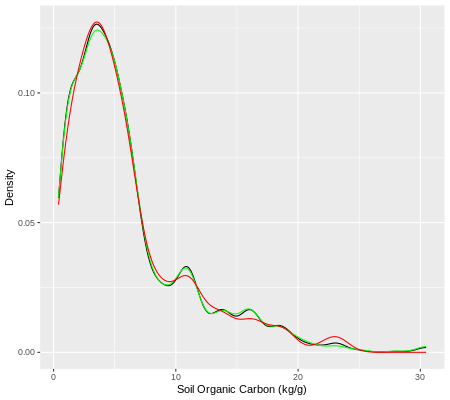

In [8]:
%%R -w 450 -h 400 -u px
ggplot()+
  geom_density(data = dummies.df, aes(SOC))+
  geom_density(data = df_train, aes(SOC), color = "green")+
  geom_density(data = df_test, aes(SOC), color = "red") +
      xlab("Soil Organic Carbon (kg/g)") +
     ylab("Density")

### Set control prameters

In [9]:
%%R
train.control <- trainControl(method = "repeatedcv",
                              number = 10, repeats = 5,
                              preProc = c("center", "scale", "nzv"))

### Lesso Regression

In [10]:
%%R
model.lasso <- train(SOC ~., data = df_train,
                     method = "glmnet",
                     tuneGrid = expand.grid(alpha =1, lambda =1),
                     trControl = train.control)
print(model.lasso)

glmnet 

1127 samples
  16 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1015, 1015, 1013, 1015, 1014, 1014, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  4.085638  0.3993098  2.979998

Tuning parameter 'alpha' was held constant at a value of 1
Tuning
 parameter 'lambda' was held constant at a value of 1


### Ridge Regression

In [11]:
%%R
model.ridge <- train(SOC ~., data = df_train,
                     method = "glmnet",
                     tuneGrid = expand.grid(alpha =0, lambda =1),
                     trControl = train.control)
print(model.ridge)

glmnet 

1127 samples
  16 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 1015, 1014, 1014, 1015, 1014, 1015, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  3.903191  0.4089925  2.811483

Tuning parameter 'alpha' was held constant at a value of 0
Tuning
 parameter 'lambda' was held constant at a value of 1


### Prediction

In [12]:
%%R
df_test$Pred.lasso = predict(model.lasso, df_test)
df_test$Pred.ridge = predict(model.ridge, df_test)

### Model Performance

In [13]:
%%R
RMSE.lasso<- Metrics::rmse(df_test$SOC, df_test$Pred.lasso)
RMSE.ridge<- Metrics::rmse(df_test$SOC, df_test$Pred.ridge)

In [14]:
%%R
RMSE.lasso

[1] 4.011978


In [15]:
%%R
RMSE.ridge

[1] 3.830918



### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

In [19]:
%%R
formula<-y~x
# Lasso Regression
p1=ggplot(df_test, aes(SOC,Pred.lasso)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Lasso Regression ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

# Ridge Regression

formula<-y~x
p2=ggplot(df_test, aes(SOC,Pred.ridge)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Ridge Regression") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))



### Plot side by sise

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


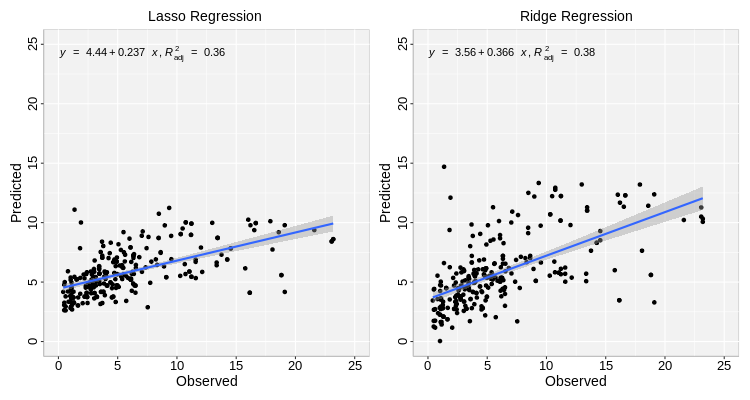

In [20]:
%%R -w 750 -h 400 -u px
p1+p2

### Train Elastic Net Regessiion

The elastic net regression can be easily computed using the caret workflow, with glmnet package. Caret to automatically select the best tuning parameters alpha and lambda. This packages tests a range of possible alpha and lambda values, then selects the best values for lambda and alpha, resulting to a final model that is an elastic net model.

Here, we’ll test the combination of 10 different values for alpha and lambda. This is specified using the option tuneLength. The best alpha and lambda values are those values that minimize the cross-validation error.


In [21]:
%%R
# Elastic Net Regression
model.elasticNet <- train(SOC ~., data = df_train,
                     method = "glmnet",
                     trControl = train.control,
                     tuneLength = 10)

#### The Best tuning parameter


In [22]:
%%R
model.elasticNet$bestTune

   alpha    lambda
33   0.4 0.2066255


#### Model coefficients

In [23]:
%%R
coef(model.elasticNet$finalModel, model.elasticNet$bestTune$lambda)

17 x 1 sparse Matrix of class "dgCMatrix"
                                     s1
(Intercept)                -0.047733077
DEM                         .          
Slope                       0.108541471
TPI                         0.009711866
MAT                        -0.174860510
MAP                         0.006529288
NDVI                        9.833128195
NLCDForest                  0.344862763
NLCDHerbaceous              .          
`NLCDPlanted/Cultivated`   -0.370638998
NLCDShrubland               .          
`FRGFire Regime Group I`    .          
`FRGFire Regime Group II`   0.009074569
`FRGFire Regime Group III` -0.221335283
`FRGFire Regime Group IV`   .          
`FRGFire Regime Group V`    .          
`FRGIndeterminate FRG`     -0.182487865


### Prediction

In [24]:
%%R
df_test$Pred.elasticNET = predict(model.elasticNet, df_test)

In [25]:
%%R
RMSE.elasticNET<- Metrics::rmse(df_test$SOC, df_test$Pred.elasticNET)
RMSE.elasticNET

[1] 3.855277


`geom_smooth()` using formula = 'y ~ x'


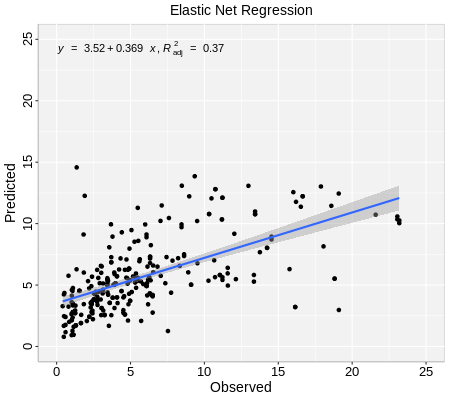

In [26]:
%%R -w 450 -h 400 -u px
formula<-y~x
ggplot(df_test, aes(SOC,Pred.elasticNET)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Elastic Net Regression") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## Ridge Regressions with tidymodels

The tidymodels provides a comprehensive framework for building, tuning, and evaluating regularized GLM models in R while following the principles of the tidyverse.

### Data split

We use **rsample** package, install with **tidymodels**, to split data into training (70%) and test data (30%) set with Stratified Random Sampling. initial_split() creates a single binary split of the data into a training set and testing set.

In [28]:
%%R
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()
# Set 10 fold cross-validation data set
cv_fold <- vfold_cv(train, v = 10)

### Create Recipe

A recipe is a description of the steps to be applied to a data set in order to prepare it for data analysis. Before training the model, we can use a recipe to do some preprocessing required by the model.

In [29]:
%%R
model_recipe <-
  recipe(SOC ~ ., data = train) %>%
  step_zv(all_predictors()) %>%
  step_dummy(all_nominal()) %>%
  step_normalize(all_numeric_predictors())

### Build a Ridge Regression model

The function **set_engine()** is used to specify which package or system will be used to fit the model, along with any arguments specific to that software. We will use "glm" without any regularization parameters. The mixture argument specifies the amount of different types of regularization; mixture = 0 specifies only ridge regularization and mixture = 1 specifies only lasso regularization. When using the glmnet engine, we also need to set a penalty to be able to fit the model. The penalty = tune() tells tune_grid() that penalty parameter should be tuned.

In [30]:
%%R
ridge_mod <-
   linear_reg(mixture = 0, penalty = tune()) %>%

   set_mode("regression") %>%
   set_engine("glmnet")

#### Creatae a workflow

A workflow is a container object that aggregates information required to fit and predict from a model. This information might be a recipe used in pre-processing, specified through add_recipe(), or the model specification to fit, specified through add_model().

In [31]:
%%R
ridge_wflow <-
  workflow() %>%
  add_model(ridge_mod) %>%
  add_recipe(model_recipe)

#### Set Penalty Grid

This can be created using grid_regular() which creates a grid of evenly spaces parameter values. We use the penalty() function from the dials package to denote the parameter and set the range of the grid we are searching for. Note that this range is log-scaled.

In [32]:
%%R
penalty_grid <- grid_regular(penalty(range = c(-5, 5)), levels = 50)
penalty_grid

# A tibble: 50 × 1
     penalty
       <dbl>
 1 0.00001  
 2 0.0000160
 3 0.0000256
 4 0.0000409
 5 0.0000655
 6 0.000105 
 7 0.000168 
 8 0.000268 
 9 0.000429 
10 0.000687 
# ℹ 40 more rows
# ℹ Use `print(n = ...)` to see more rows


#### Grid search for the best penalty

In [33]:
%%R
tune_res <- tune_grid(
  ridge_wflow,
  resamples = cv_fold,
  grid = penalty_grid
)

tune_res

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.
There were issues with some computations   A: x1
There were issues with some computations   A: x2
There were issues with some computations   A: x3
There were issues with some computations   A: x4
There were issues with some computations   A: x5
There were issues with some computations   A: x6
There were issues with some computations   A: x7
There were issues with some computations   A: x8
There were issues with some computations   A: x9
There were issues with some computations   A: x10
There were issues with some computations   A: x10

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 × 4
   splits             id     .metrics           .notes          
   <list>             <chr>  <list>             <list>          
 1 <split [1013/113]> Fold01 <tibble [100 × 5]> <tibble [1 × 3]>
 2 <split [1013/113]> Fold02 <t

The output of tune_grid() can be visualize with autoplot() function:

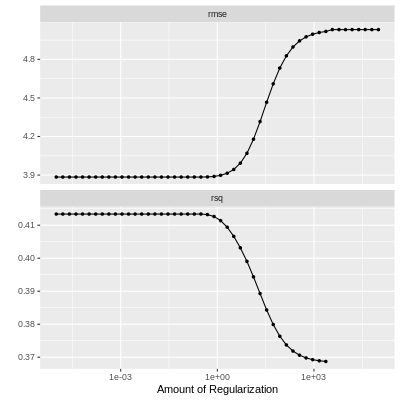

In [34]:
%%R -w 400 -h 400 -u px
autoplot(tune_res)

We can also see the raw metrics that created this chart by calling collect_matrics():

In [ ]:
%%R
collect_metrics(tune_res)

# A tibble: 100 × 7
     penalty .metric .estimator  mean     n std_err .config              
       <dbl> <chr>   <chr>      <dbl> <int>   <dbl> <chr>                
 1 0.00001   rmse    standard   3.90     10  0.300  Preprocessor1_Model01
 2 0.00001   rsq     standard   0.393    10  0.0399 Preprocessor1_Model01
 3 0.0000160 rmse    standard   3.90     10  0.300  Preprocessor1_Model02
 4 0.0000160 rsq     standard   0.393    10  0.0399 Preprocessor1_Model02
 5 0.0000256 rmse    standard   3.90     10  0.300  Preprocessor1_Model03
 6 0.0000256 rsq     standard   0.393    10  0.0399 Preprocessor1_Model03
 7 0.0000409 rmse    standard   3.90     10  0.300  Preprocessor1_Model04
 8 0.0000409 rsq     standard   0.393    10  0.0399 Preprocessor1_Model04
 9 0.0000655 rmse    standard   3.90     10  0.300  Preprocessor1_Model05
10 0.0000655 rsq     standard   0.393    10  0.0399 Preprocessor1_Model05
# ℹ 90 more rows
# ℹ Use `print(n = ...)` to see more rows


The “best” values of this can be selected using select_best(), this function requires us to specify a matric that it should select against.

In [35]:
%%R
best_penalty <- select_best(tune_res, metric = "rsq")
best_penalty

# A tibble: 1 × 2
  penalty .config              
    <dbl> <chr>                
1   0.309 Preprocessor1_Model23


#### Fit the model with the best penalty value

This value of penalty can then be used with finalize_workflow() to update/finalize the recipe by replacing tune() with the value of best_penalty. Now, this model should be fit again, this time using the whole training data set.

In [36]:
%%R
# update penalty
ridge_final <- finalize_workflow(ridge_wflow, best_penalty)
# fit the model
ridge_final_fit <- fit(ridge_final,
                       data = train)

This object has the finalized recipe and fitted model objects inside. You may want to extract the model or recipe objects from the workflow. To do this, you can use the helper functions extract_fit_parsnip():

In [37]:
%%R
ridge_final_fit %>%
  extract_fit_parsnip() %>%
  tidy()

# A tibble: 15 × 3
   term                      estimate penalty
   <chr>                        <dbl>   <dbl>
 1 (Intercept)                6.06      0.309
 2 DEM                        0.113     0.309
 3 Slope                      0.615     0.309
 4 TPI                        0.0896    0.309
 5 MAT                       -0.790     0.309
 6 MAP                        0.867     0.309
 7 NDVI                       1.46      0.309
 8 NLCD_Herbaceous           -0.443     0.309
 9 NLCD_Planted.Cultivated   -0.573     0.309
10 NLCD_Shrubland            -0.252     0.309
11 FRG_Fire.Regime.Group.II   0.388     0.309
12 FRG_Fire.Regime.Group.III -0.140     0.309
13 FRG_Fire.Regime.Group.IV  -0.0826    0.309
14 FRG_Fire.Regime.Group.V   -0.00578   0.309
15 FRG_Indeterminate.FRG     -0.0725    0.309


### Prediction

In [38]:
%%R
test$ridge.SOC<-as.data.frame(predict(ridge_final_fit, new_data = test))

In [39]:
%%R
RMSE<- Metrics::rmse(test$SOC, test$ridge.SOC$.pred)
RMSE

[1] 3.811666


In [40]:
%%R
MAE<- Metrics::mae(test$SOC, test$ridge.SOC$.pred)
MAE

[1] 2.7097


In [41]:
%%R
augment(ridge_final_fit, new_data = test) %>%
  rsq(truth = SOC, estimate = .pred)

# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rsq     standard       0.408


`geom_smooth()` using formula = 'y ~ x'


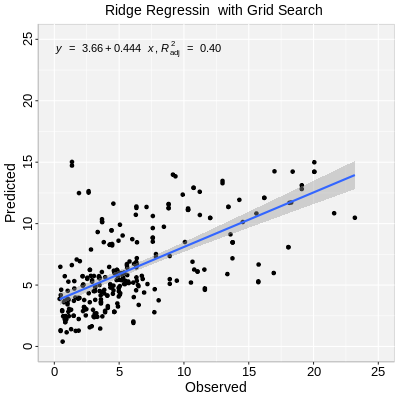

In [42]:
%%R -w 400 -h 400 -u px
formula<-y~x
ggplot(test, aes(SOC,ridge.SOC$.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Ridge Regressin  with Grid Search ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## GLM with h20

The h2o package provides an open-source implementation of GLM that is specifically designed for big data. To use the GLM function in h2o, you will need to first install and load the package in your R environment.

H2O supports elastic net regularization, which is a combination of the l1 and l2 penalties parametrized by the alpha and lambda arguments.

**alpha** controls the elastic net penalty distribution between the l1 and l2 norms. It can have any value in the [0; 1] range or a vector of values (which triggers grid search). If alpha = 0, H2O solves the GLM using ridge regression. If alpha = 1, the Lasso penalty is used.

**lambda** controls the penalty strength. The range is any positive value or a vector of values (which triggers grid search).

We will use Random Grid Search (RGS) to find the optimal parameters for  the GLM models. We employ  the K-fold cross validation method to determine the optimal hyper-parameters from a set of all possible hyper-parameter value combinations of alpha and lambda.

We can view the results of the grid search by printing the grid object. We can use this information to select the best model based on its CV performance  and then use it to make predictions on new data.

### Load h2o

In [ ]:
%%R
library(h2o)
h2o.init()
#disable progress bar for RMarkdown
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()

### Data

In [44]:
%%R
# load data
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, Aspect, TPI, KFactor, SiltClay, MAT, MAP,NDVI, NLCD, FRG)
# convrt factor
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)
# Split data
set.seed(1245)   # for reproducibility
split <- initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()
# Scale data
train[-c(1, 11,12)] = scale(train[-c(1,11,12)])
test[-c(1, 11,12)] = scale(test[-c(1,11,12)])

Rows: 467 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD, FRG
dbl (15): ID, FIPS, STATE_ID, Longitude, Latitude, SOC, DEM, Aspect, Slope, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Import data into h2o cluster

In [45]:
%%R
h_df=as.h2o(df)
h_train = as.h2o(train)
h_test = as.h2o(test)

In [46]:
%%R
CV.xy<- as.data.frame(h_train)
test.xy<- as.data.frame(h_test)

### Define response and predictors

In [47]:
%%R
y <- "SOC"
x <- setdiff(names(h_df), y)

### Grid Search for Hyperprameter

We must find the optimal values of the alpha and lambda regularization parameters to get the best possible model. To find the optimal values, H2O provides grid search over alpha and lambda and a particular form of grid search called "lambda search" over lambda. For a detailed explanation, refer to Regularization. The recommended way to find optimal regularization settings on H2O is to do a grid search over a few alpha values with an automatic lambda search for each alpha.

The alpha parameter controls the distribution between the l1 (Lasso) and l2 (Ridge regression) penalties. A value of 1.0 for alpha represents Lasso, and an alpha value of 0.0 produces ridge regression. The lambda parameter controls the amount of regularization applied. If lambda is 0.0, no regularization is applied and the alpha parameter is ignored. The default value for lambda is calculated by H2O using a heuristic based on the training data. If you let H2O calculate the value for lambda, you can see the chosen value in the model output.

To perform a hyperparameter grid search in h2o R, you can use the h2o.grid() function. This function takes a set of hyperparameters and their corresponding values, and trains and evaluates models with all possible combinations of those hyperparameters.

In [48]:
%%R
# prameters
glm_hyper_params <-list(
             alpha = c(0,0.25,0.5,0.75,1),
             lambda = c(1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0))
glm_grid <- h2o.grid(
                  algorithm="glm",
                  grid_id = "glm_grid_ID",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  standardize = TRUE,
                  nfolds=10,
                  keep_cross_validation_predictions = TRUE,
                  hyper_params = glm_hyper_params,
                  seed = 42)

### Grid parameters

In [49]:
%%R
glm_get_grid <- h2o.getGrid("glm_grid_ID",sort_by="RMSE",decreasing=FALSE)
glm_get_grid@summary_table[1,]
# number of models
length(glm_grid@model_ids)

[1] 40


### The best GLM

In [50]:
%%R
best_glm <- h2o.getModel(glm_get_grid@model_ids[[1]])
summary(best_glm)

Model Details:

H2ORegressionModel: glm
Model Key:  glm_grid_ID_model_14 
GLM Model: summary
    family     link                            regularization
1 gaussian identity Elastic Net (alpha = 0.75, lambda = 0.1 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                         19                           8                    2
    training_frame
1 train_sid_a0ed_3

H2ORegressionMetrics: glm
** Reported on training data. **

MSE:  14.79506
RMSE:  3.846435
MAE:  2.684092
RMSLE:  0.4910106
Mean Residual Deviance :  14.79506
R^2 :  0.4097689
Null Deviance :9299.692
Null D.o.F. :370
Residual Deviance :5488.967
Residual D.o.F. :362
AIC :2072.435



H2ORegressionMetrics: glm
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  15.83711
RMSE:  3.979587
MAE:  2.767983
RMSLE:  0.5027996
Mean Residual Deviance :  15.83711
R^2 :  0.3681975
Null Deviance :9353.5

### Model Performance

In [51]:
%%R
# training
 h2o.performance(best_glm, h_train)


H2ORegressionMetrics: glm

MSE:  14.79506
RMSE:  3.846435
MAE:  2.684092
RMSLE:  0.4910106
Mean Residual Deviance :  14.79506
R^2 :  0.4097689
Null Deviance :9299.692
Null D.o.F. :370
Residual Deviance :5488.967
Residual D.o.F. :362
AIC :2072.435



In [54]:
%%R
# CV - prediction
pred.cv<-as.data.frame(h2o.getFrame(best_glm@model[["cross_validation_holdout_predictions_frame_id"]][["name"]]))
# Get CV predicted values
CV.xy$SOC.pred<-pred.cv$predict
# Get several Metrics
cv.lm<-lm(SOC ~ SOC.pred, CV.xy)
cv.matrics <- cbind("RMSE"=Metrics::rmse(CV.xy$SOC, CV.xy$SOC.pred),
              "MAE"=Metrics::mae(CV.xy$SOC, CV.xy$SOC.pred),
              "Bias"=Metrics::bias(CV.xy$SOC, CV.xy$SOC.pred),
              "MSE"= Metrics::mse(CV.xy$SOC, CV.xy$SOC.pred),
              "MDAE"=Metrics::mdae(CV.xy$SOC, CV.xy$SOC.pred),
               "R2"= summary(cv.lm)$r.squared
                  )
cv.matrics

         RMSE      MAE        Bias      MSE     MDAE        R2
[1,] 3.979587 2.767983 -0.01749009 15.83711 1.852055 0.3682142


In [58]:
%%R
# test performance
h2o.performance(best_glm, h_test)




H2ORegressionMetrics: glm

MSE:  11.84644
RMSE:  3.441866
MAE:  2.557466
RMSLE:  0.4886231
Mean Residual Deviance :  11.84644
R^2 :  0.5560368
Null Deviance :2563.204
Null D.o.F. :95
Residual Deviance :1137.258
Residual D.o.F. :87
AIC :529.7508



### Prediction

In [59]:
%%R
test.pred<-as.data.frame(h2o.predict(object = best_glm,newdata = h_test))
test.xy$SOC.pred<-test.pred$predict
test.lm<-lm(SOC ~ SOC.pred, test.xy)
test.matrics <- cbind("RMSE"=Metrics::rmse(test.xy$SOC, test.xy$SOC.pred),
              "MAE"=Metrics::mae(test.xy$SOC, test.xy$SOC.pred),
              "Bias"=Metrics::bias(test.xy$SOC, test.xy$SOC.pred),
              "MSE"= Metrics::mse(test.xy$SOC, test.xy$SOC.pred),
              "MDAE"=Metrics::mdae(test.xy$SOC, CV.xy$SOC.pred),
              "R2"= summary(test.lm)$r.squared
              )
test.matrics

         RMSE      MAE      Bias      MSE    MDAE        R2
[1,] 3.441866 2.557467 0.1384233 11.84644 3.30778 0.5798946


`geom_smooth()` using formula = 'y ~ x'


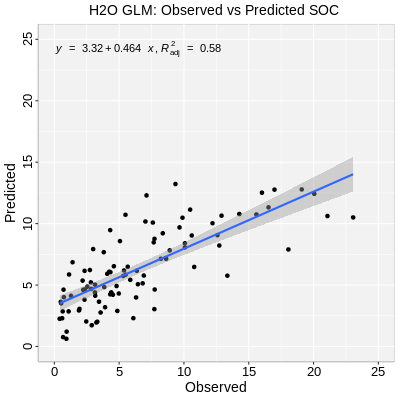

In [60]:
%%R -w 400 -h 400 -u px
test.pred<-as.data.frame(h2o.predict(object = best_glm,newdata = h_test))
test.xy$SOC.pred<-test.pred$predict
formula<-y~x

ggplot(test.xy, aes(SOC,SOC.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("H2O GLM: Observed vs Predicted SOC ") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Variable Importnace

Variable importance in GLM regression model represents the coefficient magnitudes. The standardized coefficients are returned if the standardize option is enabled (which is the default). These are the predictor weights of the standardized data and are included only for informational purposes like comparing the relative variable importance.

In [ ]:
%%R
h2o.varimp(best_glm)

Variable Importances: 
  variable relative_importance scaled_importance percentage
1     NDVI            1.469057          1.000000   0.326869
2      MAP            0.960991          0.654155   0.213823
3      MAT            0.929065          0.632423   0.206719
4    Slope            0.742492          0.505421   0.165206
5 SiltClay            0.314929          0.214375   0.070073
6      TPI            0.073287          0.049887   0.016306
7  KFactor            0.004513          0.003072   0.001004
8      DEM            0.000000          0.000000   0.000000
9   Aspect            0.000000          0.000000   0.000000


To plot variable importance for the model, we use the h2o.varimp_plot() function and pass the trained model as an argument. The function generates a bar plot of the relative importance of each input variable, sorted in descending order by importance.

The h2o.varimp_plot() function also has several optional arguments that you can use to customize the appearance of the plot, such as num_of_features to limit the number of features displayed on the plot, title to set a title for the plot, and col to set the color of the bars.

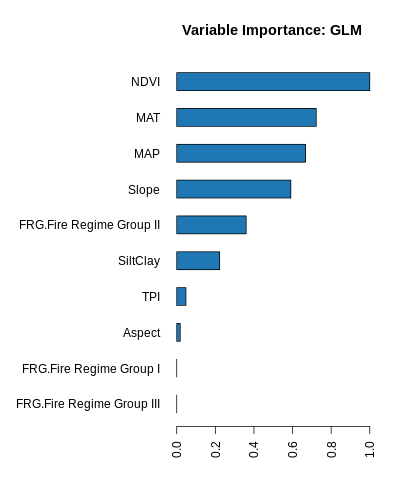

In [61]:
%%R -w 400 -h 500 -u px
h2o.varimp_plot(best_glm)

### Further Reading

1. [Linear Model Selection and Regularization](https://emilhvitfeldt.github.io/ISLR-tidymodels-labs/06-regularization.html)

2. [Grid Search H20](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html)

3. [H20 variable importance](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/variable-importance.html)


###  YouTube Video

1. Regularization Part 1: Ridge (L2) Regression

{{< video https://www.youtube.com/watch?v=Q81RR3yKn30 >}}

Source: [StatQuest with Josh Starme](https://www.youtube.com/@statquest)

2. Regularization Part 2: Lasso (L1) Regression

{{< video https://www.youtube.com/watch?v=Q81RR3yKn30 >}}

Source: [StatQuest with Josh Starme](https://www.youtube.com/@statquest)